## Manejo de Datos Faltantes y Outliers - Día 5

## Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
#from scipy import stats

## Crear dataset con problemas

In [2]:
# Crear dataset con missing values y outliers
np.random.seed(42)
n = 1000

datos = pd.DataFrame({
    'id': range(1, n+1),
    'edad': np.random.normal(35, 10, n).clip(18, 80),  # Normal con límites
    'salario': np.random.lognormal(10, 0.5, n),  # Distribución log-normal
    'horas_trabajo': np.random.normal(40, 5, n).clip(20, 60),
    'satisfaccion': np.random.randint(1, 6, n),
    'departamento': np.random.choice(['IT', 'Ventas', 'Marketing', 'HR'], n)
})

# Introducir missing values
mask_missing = np.random.random(n) < 0.1  # 10% missing
datos.loc[mask_missing, 'salario'] = np.nan

mask_missing_horas = np.random.random(n) < 0.05  # 5% missing
datos.loc[mask_missing_horas, 'horas_trabajo'] = np.nan

# Introducir outliers
outlier_indices = np.random.choice(n, 20, replace=False)
datos.loc[outlier_indices[:10], 'salario'] = datos.loc[outlier_indices[:10], 'salario'] * 10  # Salarios extremos altos
datos.loc[outlier_indices[10:], 'horas_trabajo'] = np.random.choice([80, 90, 100], 10)  # Horas imposibles

print(f"Dataset creado: {datos.shape}")
print(f"Valores faltantes por columna:\n{datos.isnull().sum()}")

Dataset creado: (1000, 6)
Valores faltantes por columna:
id                0
edad              0
salario          95
horas_trabajo    46
satisfaccion      0
departamento      0
dtype: int64


## Analizar datos faltantes

Porcentaje de datos faltantes:
id               0.0
edad             0.0
salario          9.5
horas_trabajo    4.6
satisfaccion     0.0
departamento     0.0
dtype: float64

Missing values por departamento:
              id  edad  salario  horas_trabajo  satisfaccion
departamento                                                
HR             0     0       20             13             0
IT             0     0       18              3             0
Marketing      0     0       23             17             0
Ventas         0     0       34             13             0


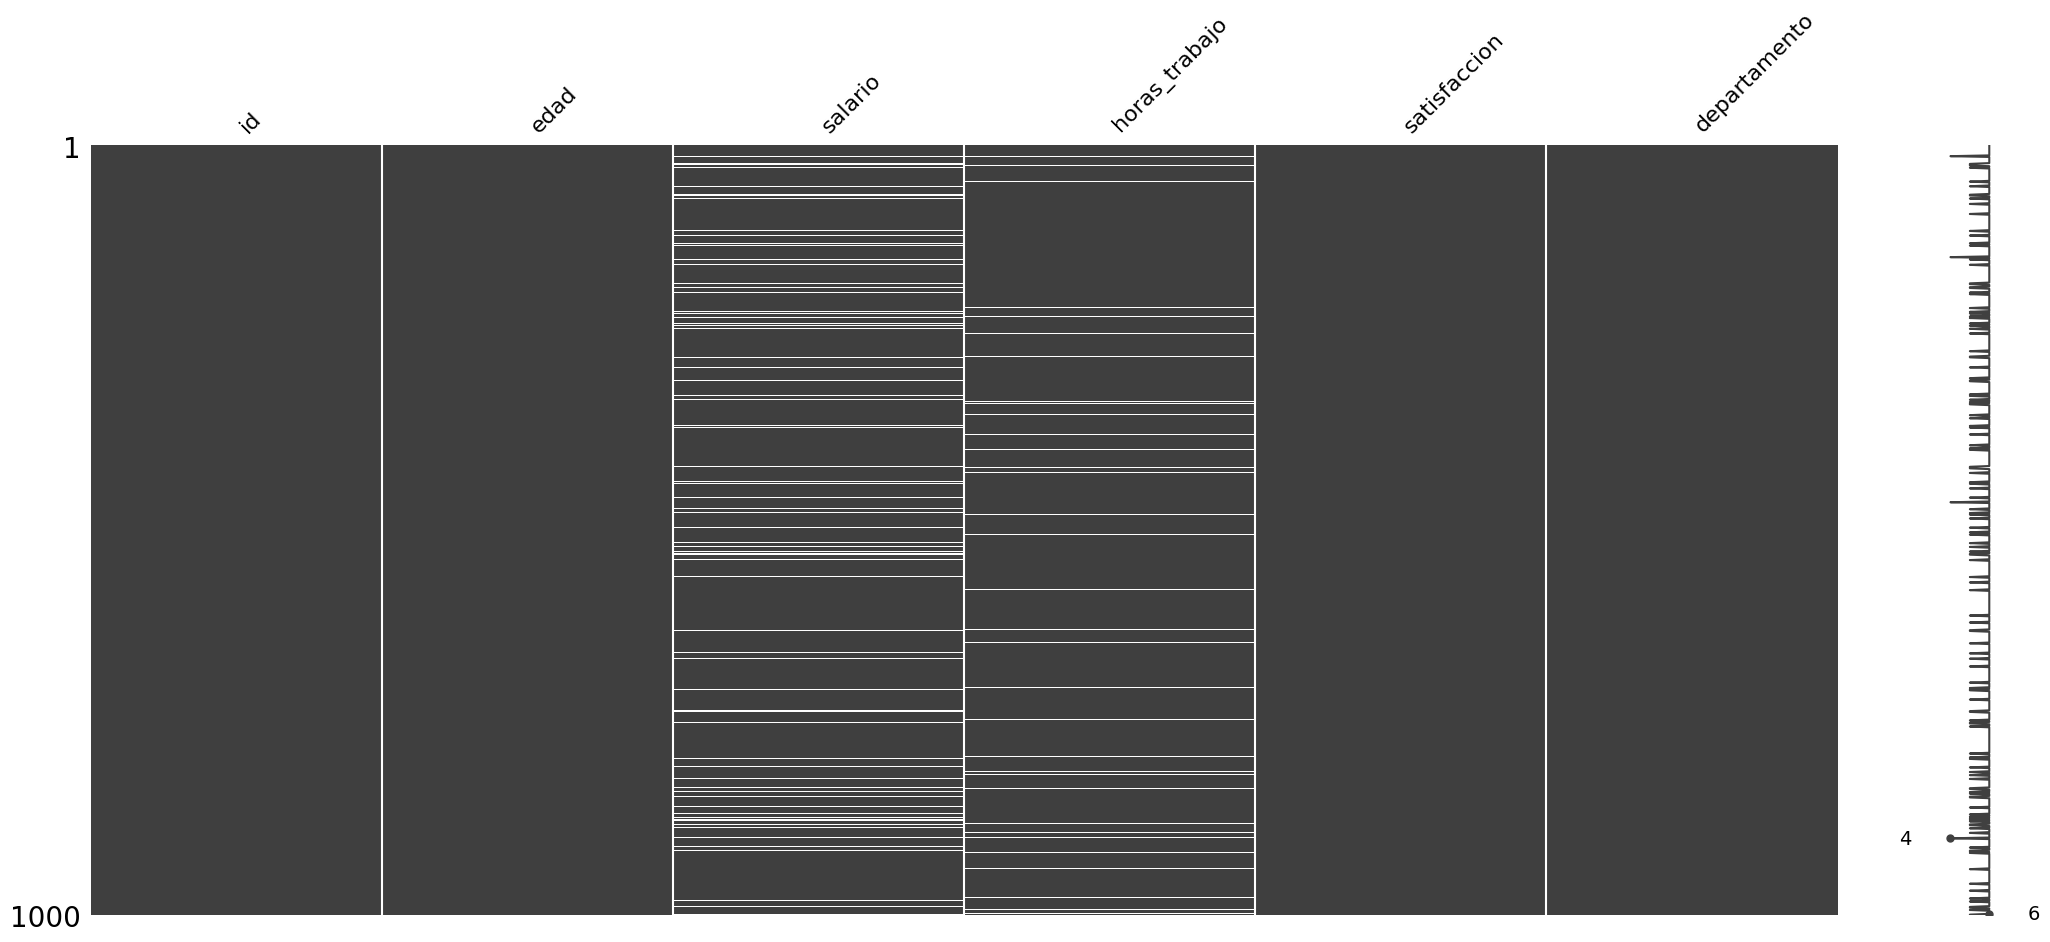

In [3]:
# Análisis detallado de missing values
print("Porcentaje de datos faltantes:")
print((datos.isnull().sum() / len(datos) * 100).round(2))

# Patrón de missing values
msno.matrix(datos)  # Visualización (requiere instalar missingno)

# Análisis por departamento
print("\nMissing values por departamento:")
print(datos.groupby('departamento').agg(lambda x: x.isnull().sum()))

## Imputación de valores faltantes

In [4]:
# Imputación por media para horas_trabajo
media_horas = datos['horas_trabajo'].mean()
datos['horas_trabajo'] = datos['horas_trabajo'].fillna(media_horas)

# Imputación por mediana para salario (más robusto a outliers)
mediana_salario = datos['salario'].median()
datos['salario'] = datos['salario'].fillna(mediana_salario)

# Verificar que no queden missing values
print(f"\nValores faltantes después de imputación: {datos.isnull().sum().sum()}")


Valores faltantes después de imputación: 0


## Detección de outliers

In [5]:
# Función para detectar outliers usando IQR
def detectar_outliers_iqr(data, columna):
    Q1 = data[columna].quantile(0.25)
    Q3 = data[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    return (data[columna] < limite_inferior) | (data[columna] > limite_superior)

# Detectar outliers en salario y horas
outliers_salario = detectar_outliers_iqr(datos, 'salario')
outliers_horas = detectar_outliers_iqr(datos, 'horas_trabajo')

print(f"\nOutliers detectados:")
print(f"Salario: {outliers_salario.sum()} ({outliers_salario.mean()*100:.1f}%)")
print(f"Horas trabajo: {outliers_horas.sum()} ({outliers_horas.mean()*100:.1f}%)")


Outliers detectados:
Salario: 55 (5.5%)
Horas trabajo: 24 (2.4%)


## Manejo de outliers

### Outliers de horas_trabajo

In [6]:
# Estadísticas de horas_trabajo original
stats_horas_orig = datos['horas_trabajo'].describe().round(2)

# Para horas_trabajo: cap at reasonable maximum
max_horas_normales = 60
datos.loc[datos['horas_trabajo'] > max_horas_normales, 'horas_trabajo'] = max_horas_normales

# Estadísticas de horas_trabajo acotadas superiormente
stats_horas_cota_sup = datos['horas_trabajo'].describe().round(2)

# Comparar estadísticas antes y después
print('\nComparación de estadísticas para horas_trabajo:')
print(pd.DataFrame({'valores originales':stats_horas_orig, 'valores acotados':stats_horas_cota_sup}))

# Verificar reducción de outliers
print(f"\nOutliers detectados en horas_trabajo luego de manejarlas acotándolas superiormente:")

outliers_horas_cota_sup = detectar_outliers_iqr(datos, 'horas_trabajo')
Q1 = stats_horas_cota_sup['25%']
Q3 = stats_horas_cota_sup['75%']
whisker_inf = Q1 - 1.5 * (Q3 - Q1)
whisker_sup = Q3 + 1.5 * (Q3 - Q1) 

print(f"  - Total: {outliers_horas_cota_sup.sum()} ({outliers_horas_cota_sup.mean():.1%})")
print(f"  - Valor máximo bajo  whisker inferior: {datos.loc[outliers_horas_cota_sup & (datos['horas_trabajo']< whisker_inf), 'horas_trabajo'].max():.1f}")
print(f"  - Valor mínimo sobre whisker superior: {datos.loc[outliers_horas_cota_sup & (datos['horas_trabajo']> whisker_sup), 'horas_trabajo'].min():.1f}")


Comparación de estadísticas para horas_trabajo:
       valores originales  valores acotados
count             1000.00           1000.00
mean                40.50             40.18
std                  7.10              5.19
min                 24.90             24.90
25%                 36.90             36.90
50%                 40.20             40.20
75%                 43.16             43.16
max                100.00             60.00

Outliers detectados en horas_trabajo luego de manejarlas acotándolas superiormente:
  - Total: 24 (2.4%)
  - Valor máximo bajo  whisker inferior: 27.4
  - Valor mínimo sobre whisker superior: 53.1


**Análisis:**
- Dado que se obtienen los mismos valores para Q1 y Q3 luego del manejo con el proceso de acotamiento superior, la cantidad de outliers se mantiene. 
- El acotamiento redujo la desviación estándar y la media, por lo que se redujo la variabilidad y la asimetría causada por los outliers, lo que es útil, por ejemplo, para modelar usando regresión lineal.

### Outliers de salario

In [7]:
# Para salario: transformar usando log (más robusto)
datos['salario_log'] = np.log1p(datos['salario'])

# Comparar estadísticas antes y después

# Estadísticas de salario original
stats_salario_orig = datos['salario'].describe().round(2)

# Estadísticas de salario transformado (log)
stats_salario_log = datos['salario_log'].describe().round(2)

print('\nComparación de estadísticas para salario:')
print(pd.DataFrame({'valores originales': stats_salario_orig, 'valores log':stats_salario_log}))

# Verificar reducción de outliers

print(f"\nAntes del manejo de outliers:")
print(f"  - tasa std/mean: {(stats_salario_orig['std'] / stats_salario_orig['mean']):.1%}")
print(f"  - tasa abs(media-mediana)/std: {(abs(stats_salario_orig['mean'] - stats_salario_orig['50%']) / stats_salario_orig['std']):.1%}")

print(f"\nLuego del manejo de outliers:")

outliers_salario_log = detectar_outliers_iqr(datos, 'salario_log')
print(f"  - Outliers en salario log-transformado: {outliers_salario_log.sum()} ({outliers_salario_log.mean():.1%})")
print(f"  - tasa std/mean: {(stats_salario_log['std'] / stats_salario_log['mean']):.1%}")
print(f"  - tasa abs(media-mediana)/std: {(abs(stats_salario_log['mean'] - stats_salario_log['50%']) / stats_salario_log['std']):.1%}")


Comparación de estadísticas para salario:
       valores originales  valores log
count             1000.00      1000.00
mean             28034.05        10.06
std              31587.51         0.53
min               5063.46         8.53
25%              17302.19         9.76
50%              22873.10        10.04
75%              30819.42        10.34
max             518367.29        13.16

Antes del manejo de outliers:
  - tasa std/mean: 112.7%
  - tasa abs(media-mediana)/std: 16.3%

Luego del manejo de outliers:
  - Outliers en salario log-transformado: 29 (2.9%)
  - tasa std/mean: 5.3%
  - tasa abs(media-mediana)/std: 3.8%


**Análisis:**
- El efecto de la transformación con log fue la reducción del número de outliers de 55 a 29.
- Antes de la transformación:
    - la desviación estándar era superior a la media de los datos.
    - el valor absoluto de la diferencia entre media y mediana era de un 16.3% del valor de la desviación estándar.
- Con la transformación:
    - la desviación estándar es aproximadamente el 5.3% del valor de la media.
    - el valor absoluto de la diferencia entre media y mediana es de solo un 3.8% del valor de la desviación estándar.
    - hay una clara reducción de la variabilidad y asimetría de los datos.